In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model



In [ ]:
# Cargar el modelo desde Google Drive
model = load_model(".../best_model.keras", compile=False)

In [8]:
import os

# Define the filename of the model
filename = "best_model.keras"  # Solo escribe el nombre del archivo aquí

# Get the current directory and construct the full file path
current_dir = os.getcwd()
filepath = os.path.join(current_dir, filename)
print(filepath)

# Check if the file exists in the current directory
if os.path.isfile(filepath):
    print(f"✅ Archivo encontrado: {filepath}")
    model = load_model(filepath, compile=False)
    print("Modelo cargado exitosamente.")
else:
    print(f"❌ Archivo no encontrado: {filename} no existe en el directorio actual.")

/content/best_model.keras
❌ Archivo no encontrado: best_model.keras no existe en el directorio actual.


## Displays the differents operations.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


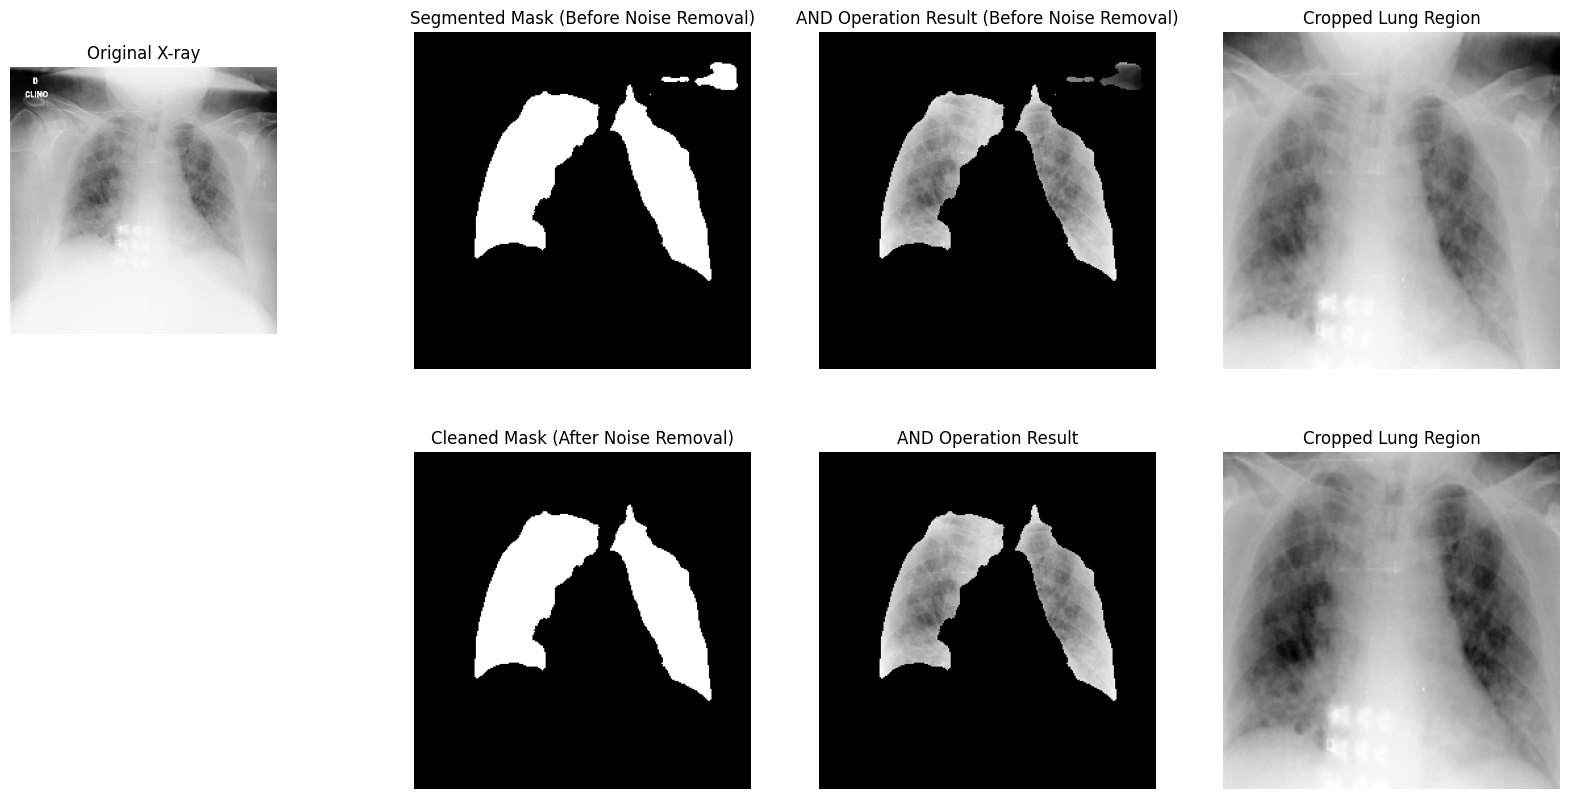

In [ ]:
# This code displays the different masks, square cuts, and comparisons between noisy and noise-free images.


from skimage.measure import label, regionprops



def preprocess_image(image_path, target_size=(256, 256)):
    """Load an X-ray image, convert to grayscale, resize, normalize, and add dimensions."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"⚠️ Skipping {image_path}, could not read image.")
        return None
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0,1]
    return image

def filter_noise(mask, min_area=500):
    """Remove small noisy components based on area (mass filtering)."""
    labeled_mask = label(mask)  # Label connected components
    filtered_mask = np.zeros_like(mask)  # Create an empty mask

    for region in regionprops(labeled_mask):
        if region.area >= min_area:  # Keep only large regions
            filtered_mask[labeled_mask == region.label] = 1

    return filtered_mask

def get_bounding_box(mask):
    """Find the bounding box (left, right, top, bottom) of the lung region in the mask."""
    coords = np.column_stack(np.where(mask > 0))  # Get non-zero pixel coordinates
    if coords.shape[0] == 0:
        return None  # No lung detected
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return x_min, x_max, y_min, y_max

def segment_and_crop_lungs(image_path):
    """Segment lungs in an X-ray, crop using bounding box, and display the results."""
    original_image = preprocess_image(image_path)
    if original_image is None:
        return  # Skip if image cannot be loaded

    input_image = np.expand_dims(np.expand_dims(original_image, axis=-1), axis=0)  # Add batch & channel dimensions

    # Predict lung mask
    prediction = model.predict(input_image)[0]
    segmented_mask = (prediction > 0.5).astype(np.uint8)  # Convert to binary mask (0s and 1s)

    # Apply AND operation (Multiply original image by cleaned mask)
    and_result_with_noise = original_image * segmented_mask.squeeze()

    # Get bounding box coordinates
    bbox_with_noise = get_bounding_box(segmented_mask.squeeze())
    if bbox_with_noise is None:
        print(f"⚠️ No lungs detected in {image_path}, skipping...")
        return

    x_min, x_max, y_min, y_max = bbox_with_noise

    # Crop the original image using the bounding box
    cropped_image = original_image[y_min:y_max, x_min:x_max]

    # Resize back to target size for consistency
    cropped_resized_with_noise = cv2.resize(cropped_image, (256, 256))

    # Remove noise based on mass (area)
    cleaned_mask = filter_noise(segmented_mask.squeeze(), min_area=500)

    # Apply AND operation (Multiply original image by cleaned mask)
    and_result = original_image * cleaned_mask


    # Get bounding box coordinates
    bbox = get_bounding_box(cleaned_mask)
    if bbox is None:
        print(f"⚠️ No lungs detected in {image_path}, skipping...")
        return

    x_min, x_max, y_min, y_max = bbox

    # Crop the original image using the bounding box
    cropped_image = original_image[y_min:y_max, x_min:x_max]

    # Resize back to target size for consistency
    cropped_resized = cv2.resize(cropped_image, (256, 256))

    # Display the results
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 5, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original X-ray")
    plt.axis("off")

    plt.subplot(2, 4, 2)
    plt.imshow(segmented_mask.squeeze(), cmap='gray')
    plt.title("Segmented Mask (Before Noise Removal)")
    plt.axis("off")

    plt.subplot(2, 4, 3)
    plt.imshow(and_result_with_noise, cmap='gray')
    plt.title("AND Operation Result (Before Noise Removal)")
    plt.axis("off")

    plt.subplot(2, 4, 4)
    plt.imshow(cropped_resized_with_noise, cmap='gray')
    plt.title("Cropped Lung Region")
    plt.axis("off")

    plt.subplot(2, 4, 6)
    plt.imshow(cleaned_mask, cmap='gray')
    plt.title("Cleaned Mask (After Noise Removal)")
    plt.axis("off")

    plt.subplot(2, 4, 7)
    plt.imshow(and_result, cmap='gray')
    plt.title("AND Operation Result")
    plt.axis("off")

    plt.subplot(2, 4, 8)
    plt.imshow(cropped_resized, cmap='gray')
    plt.title("Cropped Lung Region")
    plt.axis("off")

    plt.show()

# 📌 Run segmentation with noise removal
image_path = "...//COVID/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg"
segment_and_crop_lungs(image_path)


## Noise mask and the original X-ray image.

In [ ]:
# This code perform an AND operation between the noise mask and the original X-ray image.

# Define input directories and output directory
INPUT_DIRS = [
    # ".../Test_Dataset/BACTERIA",
    # ".../Test_Dataset/COVID",
    ".../train/NORMAL",
    ".../train/PNEUMONIA"
]
OUTPUT_DIR = ".../Mark_with_noise_trainee"  # Folder to save AND results
os.makedirs(OUTPUT_DIR, exist_ok=True)

def preprocess_image(image_path, target_size=(256, 256)):
    """Load an X-ray image, convert to grayscale, resize, normalize."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0,1]
    return image

def process_and_save(image_path, output_path):
    """Segment lungs in an X-ray, apply AND operation, and save the result."""
    original_image = preprocess_image(image_path)
    input_image = np.expand_dims(np.expand_dims(original_image, axis=-1), axis=0)  # Add batch & channel dimensions

    # Predict lung mask
    prediction = model.predict(input_image)[0]
    segmented_mask = (prediction > 0.5).astype(np.uint8)  # Convert to binary mask (0s and 1s)

    # Apply AND operation (Multiply original image by segmented mask)
    and_result = original_image * segmented_mask.squeeze()
    and_result = (and_result * 255).astype(np.uint8)  # Convert back to 8-bit grayscale

    # Save the processed image
    cv2.imwrite(output_path, and_result)

# Process all images in all directories
def process_dataset():
    for input_dir in INPUT_DIRS:
        output_subdir = os.path.join(OUTPUT_DIR, os.path.basename(os.path.normpath(input_dir)))
        os.makedirs(output_subdir, exist_ok=True)
        image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        for i, file in enumerate(image_files):
            image_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_subdir, file)
            process_and_save(image_path, output_path)
            print(f"Processed {i+1}/{len(image_files)} in {input_dir}: {file}")

# Run the processing
process_dataset()
print("✅ All images processed and saved!")

Streaming output truncated to the last 5000 lines.
Processed 1437/3936 in /content/drive/MyDrive/Reconocimiento de Patrones/Aprendizaje - Proyecto final/NEW DATASET/DataSet_Mendeley/chest_xray/train/PNEUMONIA: person1165_virus_1959.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
Processed 1438/3936 in /content/drive/MyDrive/Reconocimiento de Patrones/Aprendizaje - Proyecto final/NEW DATASET/DataSet_Mendeley/chest_xray/train/PNEUMONIA: person1343_bacteria_3414.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
Processed 1439/3936 in /content/drive/MyDrive/Reconocimiento de Patrones/Aprendizaje - Proyecto final/NEW DATASET/DataSet_Mendeley/chest_xray/train/PNEUMONIA: person486_bacteria_2053.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
Processed 1440/3936 in /content/drive/MyDrive/Reconocimiento de Patrones/Aprendizaje - Proyecto final/NEW DATASET/DataSet_Mendeley/chest_xray/train/PNEUMONIA: person569_bacteria_2363.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
Processed 1441/3936 in /content/drive/MyDr

## Square operation with noise

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
✅ Processed 1/1349 in NORMAL: NORMAL2-IM-0918-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
✅ Processed 2/1349 in NORMAL: NORMAL2-IM-0919-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
✅ Processed 3/1349 in NORMAL: NORMAL2-IM-0917-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
✅ Processed 4/1349 in NORMAL: NORMAL2-IM-0913-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
✅ Processed 5/1349 in NORMAL: NORMAL2-IM-0915-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
✅ Processed 6/1349 in NORMAL: NORMAL2-IM-0912-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
✅ Processed 7/1349 in NORMAL: NORMAL2-IM-0914-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
✅ Processed 8/1349 in NORMAL: NORMAL2-IM-0910-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
✅ Processed 9/1349 in NORMAL: NORMAL2-IM-0911-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
✅ Processed 10/1349 in NORMAL: NORMAL2-IM-0908-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
✅ Processe

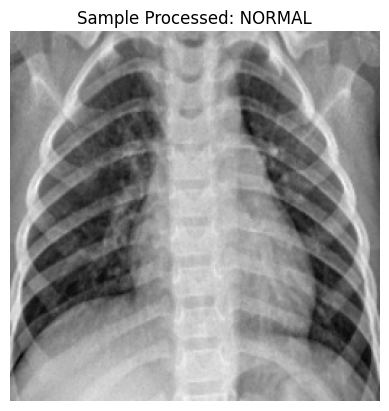

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
✅ Processed 1437/3936 in PNEUMONIA: person1165_virus_1959.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
✅ Processed 1438/3936 in PNEUMONIA: person1343_bacteria_3414.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
✅ Processed 1439/3936 in PNEUMONIA: person486_bacteria_2053.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
✅ Processed 1440/3936 in PNEUMONIA: person569_bacteria_2363.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
✅ Processed 1441/3936 in PNEUMONIA: person630_bacteria_2515.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
✅ Processed 1442/3936 in PNEUMONIA: person654_bacteria_2546.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
✅ Processed 1443/3936 in PNEUMONIA: person294_virus_610.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
✅ Processed 1444/3936 in PNEUMONIA: person1666_bacteria_4416.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
✅ Processed 1445/3936 in PNEUMONIA: person699_bacteria_2598.jpeg
1/1 ━━━━━━━━━━━━━

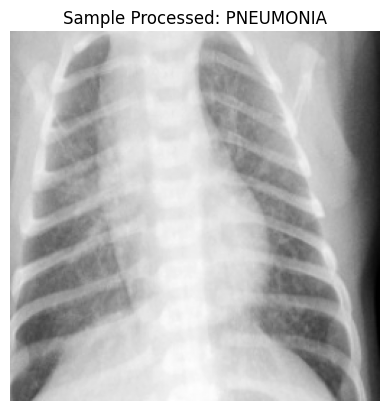

🎯 All images processed successfully!


In [ ]:
# This code performs a Square operation with noise.

# Define input and output directories
BASE_INPUT_DIR = ".../chest_xray/train"
BASE_OUTPUT_DIR = ".../Square_with_noise_trainee"
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

# List of categories to process
# CATEGORIES = ["BACTERIA", "COVID", "No-COVID", "VIRUS"]
CATEGORIES = ["NORMAL","PNEUMONIA"]
def preprocess_image(image_path, target_size=(256, 256)):
    """Load an X-ray image, convert to grayscale, resize, and normalize."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"⚠️ Skipping {image_path}, could not read image.")
        return None
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0,1]
    return image

def get_bounding_box(mask):
    """Find bounding box (left, right, top, bottom) of the lung region."""
    coords = np.column_stack(np.where(mask > 0))
    if coords.shape[0] == 0:
        return None  # No lung detected
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return x_min, x_max, y_min, y_max

def process_and_save(image_path, output_path):
    """Segment lungs, extract bounding box, crop, and save processed image."""
    original_image = preprocess_image(image_path)
    if original_image is None:
        return  # Skip if image cannot be loaded

    input_image = np.expand_dims(np.expand_dims(original_image, axis=-1), axis=0)  # Add batch & channel dimensions

    # Predict lung mask
    prediction = model.predict(input_image)[0]
    segmented_mask = (prediction > 0.5).astype(np.uint8)  # Convert to binary mask

    # Get bounding box
    bbox = get_bounding_box(segmented_mask.squeeze())
    if bbox is None:
        print(f"⚠️ No lungs detected in {image_path}, skipping...")
        return

    x_min, x_max, y_min, y_max = bbox

    # Crop the original image using the bounding box
    cropped_image = original_image[y_min:y_max, x_min:x_max]

    # Resize back to target size
    cropped_resized = cv2.resize(cropped_image, (256, 256))
    cropped_resized = (cropped_resized * 255).astype(np.uint8)  # Convert back to 8-bit grayscale

    # Save processed image
    cv2.imwrite(output_path, cropped_resized)

def process_dataset():
    """Iterate through all categories and process images."""
    for category in CATEGORIES:
        input_dir = os.path.join(BASE_INPUT_DIR, category)
        output_dir = os.path.join(BASE_OUTPUT_DIR, category)
        os.makedirs(output_dir, exist_ok=True)

        if not os.path.exists(input_dir):
            print(f"⚠️ Skipping {category}, directory does not exist.")
            continue

        image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            print(f"⚠️ No images found in {category}, skipping...")
            continue

        for i, file in enumerate(image_files):
            image_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file)
            process_and_save(image_path, output_path)
            print(f"✅ Processed {i+1}/{len(image_files)} in {category}: {file}")

        # Show a sample image after processing
        if image_files:
            sample_image = os.path.join(output_dir, image_files[0])
            sample = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)
            if sample is not None:
                plt.imshow(sample, cmap='gray')
                plt.title(f"Sample Processed: {category}")
                plt.axis("off")
                plt.show()

# Run processing
process_dataset()
print("🎯 All images processed successfully!")


## Noise-free mask and the original X-ray image

In [ ]:
# This code performs an AND operation between the noise-free mask and the original X-ray image.


from skimage.measure import label, regionprops

# Define input directories and output directory

INPUT_DIRS = [
    # ".../BACTERIA",
    # ".../COVID",
    ".../NORMAL",
    ".../PNEUMONIA"
]
OUTPUT_DIR = ".../Mark_wihtout_noise_Trainee"  # Folder to save AND results
os.makedirs(OUTPUT_DIR, exist_ok=True)

def preprocess_image(image_path, target_size=(256, 256)):
    """Load an X-ray image, convert to grayscale, resize, normalize."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0,1]
    return image

def filter_noise(mask, min_area=500):
    """Remove small noisy components based on area (mass filtering)."""
    labeled_mask = label(mask)  # Label connected components
    filtered_mask = np.zeros_like(mask)  # Create an empty mask

    for region in regionprops(labeled_mask):
        if region.area >= min_area:  # Keep only large regions
            filtered_mask[labeled_mask == region.label] = 1

    return filtered_mask

def process_and_save(image_path, output_path):
    """Segment lungs in an X-ray, apply AND operation, and save the result."""
    original_image = preprocess_image(image_path)
    input_image = np.expand_dims(np.expand_dims(original_image, axis=-1), axis=0)  # Add batch & channel dimensions

    # Predict lung mask
    prediction = model.predict(input_image)[0]
    segmented_mask = (prediction > 0.5).astype(np.uint8)  # Convert to binary mask (0s and 1s)

    # Remove noise based on mass (area)
    cleaned_mask = filter_noise(segmented_mask.squeeze(), min_area=500)

    # Apply AND operation (Multiply original image by cleaned mask)
    and_result = original_image * cleaned_mask
    and_result = (and_result * 255).astype(np.uint8)  # Convert back to 8-bit grayscale

    # Save the processed image
    cv2.imwrite(output_path, and_result)

# Process all images in all directories
def process_dataset():
    for input_dir in INPUT_DIRS:
        output_subdir = os.path.join(OUTPUT_DIR, os.path.basename(os.path.normpath(input_dir)))
        os.makedirs(output_subdir, exist_ok=True)
        image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        for i, file in enumerate(image_files):
            image_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_subdir, file)
            process_and_save(image_path, output_path)
            print(f"Processed {i+1}/{len(image_files)} in {input_dir}: {file}")

# Run the processing
process_dataset()
print("✅ All images processed and saved!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
Processed 1/234 in /content/drive/MyDrive/Reconocimiento de Patrones/Aprendizaje - Proyecto final/NEW DATASET/DataSet_Mendeley/chest_xray/test/NORMAL: IM-0031-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
Processed 2/234 in /content/drive/MyDrive/Reconocimiento de Patrones/Aprendizaje - Proyecto final/NEW DATASET/DataSet_Mendeley/chest_xray/test/NORMAL: IM-0010-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
Processed 3/234 in /content/drive/MyDrive/Reconocimiento de Patrones/Aprendizaje - Proyecto final/NEW DATASET/DataSet_Mendeley/chest_xray/test/NORMAL: NORMAL2-IM-0315-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Processed 4/234 in /content/drive/MyDrive/Reconocimiento de Patrones/Aprendizaje - Proyecto final/NEW DATASET/DataSet_Mendeley/chest_xray/test/NORMAL: NORMAL2-IM-0102-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Processed 5/234 in /content/drive/MyDrive/Reconocimiento de Patrones/Aprendizaje - Proyecto final/NEW DATASET/Dat

##  Square operation applied to the noise-free image


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
✅ Processed 1/234 in NORMAL: IM-0031-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
✅ Processed 2/234 in NORMAL: IM-0010-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
✅ Processed 3/234 in NORMAL: NORMAL2-IM-0315-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
✅ Processed 4/234 in NORMAL: NORMAL2-IM-0102-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
✅ Processed 5/234 in NORMAL: IM-0025-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
✅ Processed 6/234 in NORMAL: NORMAL2-IM-0301-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
✅ Processed 7/234 in NORMAL: NORMAL2-IM-0123-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
✅ Processed 8/234 in NORMAL: NORMAL2-IM-0229-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
✅ Processed 9/234 in NORMAL: NORMAL2-IM-0272-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
✅ Processed 10/234 in NORMAL: NORMAL2-IM-0246-0001-0002.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
✅ Processed 11/234 in NORMAL: NORMAL2-I

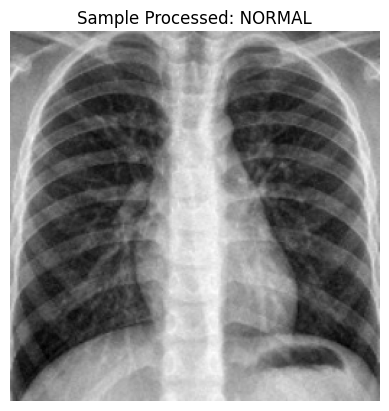

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
✅ Processed 1/390 in PNEUMONIA: person147_bacteria_706.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
✅ Processed 2/390 in PNEUMONIA: person89_bacteria_440.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
✅ Processed 3/390 in PNEUMONIA: person78_bacteria_382.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
✅ Processed 4/390 in PNEUMONIA: person138_bacteria_659.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
✅ Processed 5/390 in PNEUMONIA: person124_bacteria_589.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
✅ Processed 6/390 in PNEUMONIA: person35_virus_80.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
✅ Processed 7/390 in PNEUMONIA: person39_virus_85.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
✅ Processed 8/390 in PNEUMONIA: person1647_virus_2848.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
✅ Processed 9/390 in PNEUMONIA: person1662_virus_2875.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
✅ Processed 10/390 in PNEUMONIA: person1669_virus_2884.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━

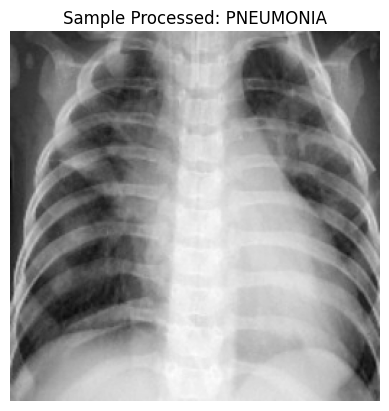

🎯 All images processed successfully!


In [ ]:
# Square operation applied to the noise-free image

# Define input and output directories
BASE_INPUT_DIR = ".../test"
BASE_OUTPUT_DIR = ".../Square_without_noise"
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

# List of categories to process
# CATEGORIES = ["BACTERIA", "COVID", "No-COVID", "VIRUS"]
CATEGORIES = ["NORMAL","PNEUMONIA"]


def preprocess_image(image_path, target_size=(256, 256)):
    """Load an X-ray image, convert to grayscale, resize, and normalize."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"⚠️ Skipping {image_path}, could not read image.")
        return None
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0,1]
    return image

def get_bounding_box(mask):
    """Find bounding box (left, right, top, bottom) of the lung region."""
    coords = np.column_stack(np.where(mask > 0))
    if coords.shape[0] == 0:
        return None  # No lung detected
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return x_min, x_max, y_min, y_max

def filter_noise(mask, min_area=500):
    """Remove small noisy components based on area (mass filtering)."""
    labeled_mask = label(mask)  # Label connected components
    filtered_mask = np.zeros_like(mask)  # Create an empty mask

    for region in regionprops(labeled_mask):
        if region.area >= min_area:  # Keep only large regions
            filtered_mask[labeled_mask == region.label] = 1

    return filtered_mask

def process_and_save(image_path, output_path):
    """Segment lungs, extract bounding box, crop, and save processed image."""
    original_image = preprocess_image(image_path)
    if original_image is None:
        return  # Skip if image cannot be loaded

    input_image = np.expand_dims(np.expand_dims(original_image, axis=-1), axis=0)  # Add batch & channel dimensions

    # Predict lung mask
    prediction = model.predict(input_image)[0]
    segmented_mask = (prediction > 0.5).astype(np.uint8)  # Convert to binary mask

    # Remove noise based on mass (area)
    cleaned_mask = filter_noise(segmented_mask.squeeze(), min_area=500)

    # Get bounding box
    bbox = get_bounding_box(cleaned_mask.squeeze())
    if bbox is None:
        print(f"⚠️ No lungs detected in {image_path}, skipping...")
        return

    x_min, x_max, y_min, y_max = bbox

    # Crop the original image using the bounding box
    cropped_image = original_image[y_min:y_max, x_min:x_max]

    # Resize back to target size
    cropped_resized = cv2.resize(cropped_image, (256, 256))
    cropped_resized = (cropped_resized * 255).astype(np.uint8)  # Convert back to 8-bit grayscale

    # Save processed image
    cv2.imwrite(output_path, cropped_resized)

def process_dataset():
    """Iterate through all categories and process images."""
    for category in CATEGORIES:
        input_dir = os.path.join(BASE_INPUT_DIR, category)
        output_dir = os.path.join(BASE_OUTPUT_DIR, category)
        os.makedirs(output_dir, exist_ok=True)

        if not os.path.exists(input_dir):
            print(f"⚠️ Skipping {category}, directory does not exist.")
            continue

        image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            print(f"⚠️ No images found in {category}, skipping...")
            continue

        for i, file in enumerate(image_files):
            image_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file)
            process_and_save(image_path, output_path)
            print(f"✅ Processed {i+1}/{len(image_files)} in {category}: {file}")

        # Show a sample image after processing
        if image_files:
            sample_image = os.path.join(output_dir, image_files[0])
            sample = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)
            if sample is not None:
                plt.imshow(sample, cmap='gray')
                plt.title(f"Sample Processed: {category}")
                plt.axis("off")
                plt.show()

# Run processing
process_dataset()
print("🎯 All images processed successfully!")
